In [169]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../data/training_sample.csv")
df.head(3)

,unitID,weekID,outcome,treatment,X1,X2,X3,C1,C2,C3
0,UNIT01155,0,470,0.0,64.225447,88362,0,M,KF7,E_2
1,UNIT01155,1,534,0.0,64.225447,87892,0,M,KF7,E_2
2,UNIT01155,2,550,0.0,64.225447,87358,0,M,KF7,E_2


# Data Characteristics

## No missing values

In [24]:
df.isnull().sum()

unitID       0
weekID       0
outcome      0
treatment    0
X1           0
X2           0
X3           0
C1           0
C2           0
C3           0
dtype: int64

## 3908 units, 95 time steps each

Each unit may represent a product. We have data on the sales (outcome) of each product for 95 weeks under different pricing strategies (treatment).

In [9]:
# No. of units
df['unitID'].nunique()

3908

In [10]:
# Time steps
df['weekID'].min(), df['weekID'].max()

(0, 94)

In [14]:
# Checking if each unit has data for 95 time steps
df['weekID'].value_counts().value_counts()

3908    95
Name: weekID, dtype: int64

## Treatment variable (Z)

### 6 Treatment levels

The treatment Z is an ordinal variable with 6 levels from 0 to 5. It is representative of different **Pricing Interventions**, with level 0 potentially representing no discount.

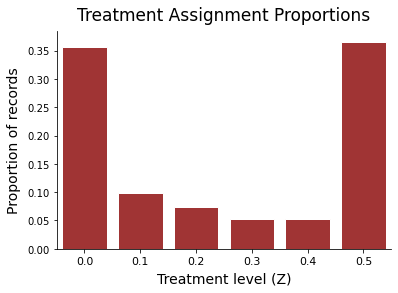

In [130]:
s = df['treatment'].value_counts()
s = s/s.sum()

plt.figure(figsize=(6,4))
sns.barplot(x=s.index, y=s.values, color="firebrick", edgecolor='white')
plt.xticks(size=11)
plt.xlabel(r"Treatment level (Z)", fontsize=14, labelpad=6)
plt.ylabel("Proportion of records", fontsize=14, labelpad=6)
plt.title("Treatment Assignment Proportions", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

1. Z=0 and Z=5 together make up over 70% of the treatment assignments.
2. Treatments 1-4 individually represent < 10% data.

### How do Treatment assignments evolve over time?

For each unit, the sequence of treatments represent a time series over 95 time steps. We can find pairwise similarities between these time series and use clustering to find if there are groups of units that had similar treatment assignments.

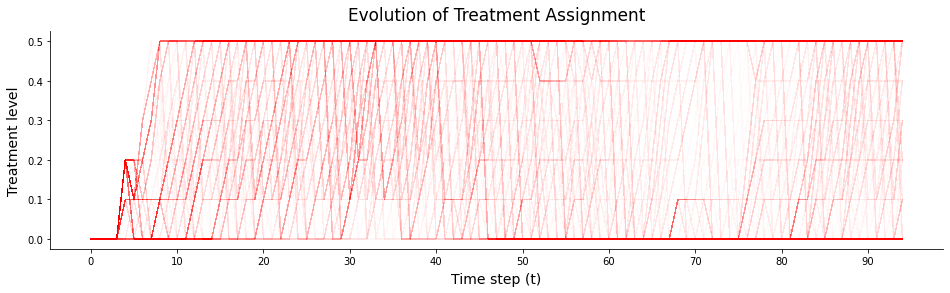

In [81]:
plt.figure(figsize=(16,4))
for unit in df['unitID'].unique()[:1000]:
    plt.plot(list(range(95)), df[df['unitID']==unit]['treatment'], alpha=0.002, color='red')

plt.xticks(list(range(0,95,10)), list(range(0,95,10)))
plt.xlabel(r"Time step (t)", fontsize=14, labelpad=6)
plt.ylabel("Treatment level (Z)", fontsize=14, labelpad=6)
plt.title("Evolution of Treatment Assignment", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

1. Although each unit has a different timeline of treatment assignments, there are common patterns (that appear as dark shades in the plot).
2. For instance, most units start with a treatment level of 0 and after 3 time steps, the treatment level is turned to 1 or 2.
3. Many units are assigned back to treatment 0 after about 45 time steps.
4. It seems like whenever the treatment level is changed to a value between 1-4, the response is tested for a few time steps (horizontal lines), based on which the treatment is modified. 

### Relationship of Treatment with outcome

In [88]:
round(np.corrcoef(df['treatment'], df['outcome'])[0,1], 3)  # Overall ~0 correlation

-0.096

/Users/sargunnagpal/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


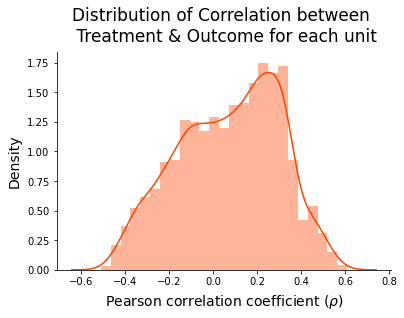

In [118]:
# Correlation between Treatment & Outcome for each unit
cors = df.groupby(by='unitID').apply(lambda x: np.corrcoef(x['treatment'], x['outcome'])[0,1])

plt.figure(figsize=(6,4))
sns.distplot(cors, color='orangered')
plt.xlabel(r"Pearson correlation coefficient $(\rho)$", fontsize=14, labelpad=6)
plt.ylabel("Density", fontsize=14, labelpad=6)
plt.title("Distribution of Correlation between \n Treatment & Outcome for each unit", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

1. Some units have a positive correlation between the treatment level and outcome, while others have a negative correlation.
2. Most units have a weak positive correlation ~0.3 (mode of the distribution).

## Outcome Variable

The outcome variable is a continuous variable that represents the **Sales** of items. It has a bimodal distribution and skewed towards the right. Most items have limited sales, evident from the peaks.

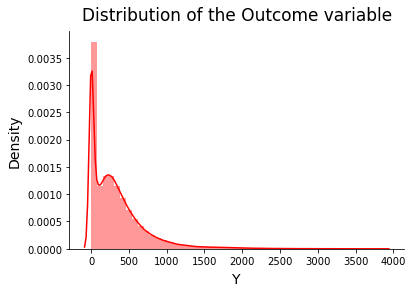

In [272]:
plt.figure(figsize=(6,4))
sns.distplot(df['outcome'], color='red')
plt.xlabel(r"Y", fontsize=14, labelpad=6)
plt.ylabel("Density", fontsize=14, labelpad=6)
plt.title("Distribution of the Outcome variable", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [276]:
print(f"""Min={round(df['outcome'].min(),2)}, Median={round(df['outcome'].median(),2)}, Mean={round(df['outcome'].mean(),2)}, Max={round(df['outcome'].max(),2)}
      """)

Min=0, Median=243.0, Mean=331.89, Max=3854
      


## Summary of Covariates

### X1

X1 is a unit-level static numeric feature, skewed towards the right. It may represent **Avg historic sales of a product**.

/Users/sargunnagpal/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


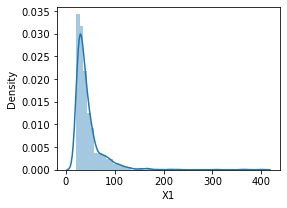

In [139]:
plt.figure(figsize=(4,3))
sns.distplot(df.groupby(by='unitID')['X1'].first())
plt.show()

### X2

X2 is a temporal numeric feature, skewed towards the right and has a range of over 150k. It may represent **Inventory count**.

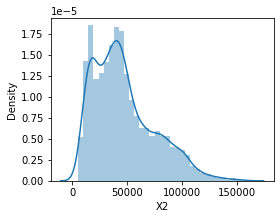

In [148]:
plt.figure(figsize=(4,3))
sns.distplot(df.groupby(by='unitID')['X2'].mean())
plt.show()

### X3

X3 is a temporal binary feature. It remains 0 for the majority of time. The avg value of the outcome (sales) increases when it's value is 1. Therefore X3 may represent whether a product is in **High Demand**.

In [151]:
df['X3'].value_counts()

0    324279
1     46981
Name: X3, dtype: int64

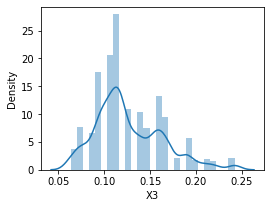

In [149]:
# Proportion of 1s for each unit
plt.figure(figsize=(4,3))
sns.distplot(df.groupby(by='unitID')['X3'].mean())
plt.show()

In [160]:
# Mean value of outcome is higher when X3=1, so it could represent High Demand
df.groupby(by=['unitID', 'X3'])['outcome'].mean()

unitID     X3
UNIT00000  0      165.977011
           1      402.500000
UNIT00001  0      169.825000
           1      499.066667
UNIT00002  0      240.147727
                    ...     
UNIT05995  1     1224.875000
UNIT05996  0      118.720930
           1     1496.444444
UNIT05997  0      103.678571
           1      962.636364
Name: outcome, Length: 7816, dtype: float64

In [161]:
df[df['X3']==1][['unitID', 'weekID']].head(10) # Almost continuous time spans of high demand

,unitID,weekID
4,UNIT01155,4
6,UNIT01155,6
7,UNIT01155,7
8,UNIT01155,8
44,UNIT01155,44
53,UNIT01155,53
54,UNIT01155,54
57,UNIT01155,57
60,UNIT01155,60
71,UNIT01155,71


### C1

C1 is a product-level static categorical variable with 15 levels. The proportion of records for each category are roughly equal. This variable may represent the **Product Category**.

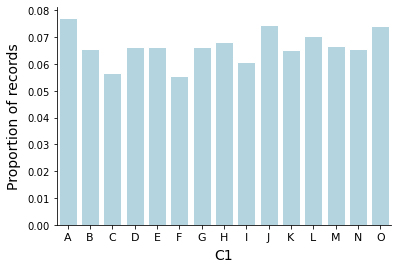

In [168]:
s = df['C1'].value_counts().sort_index()
s = s/s.sum()

plt.figure(figsize=(6,4))
sns.barplot(x=s.index, y=s.values, color="lightblue", edgecolor='white')
plt.xticks(size=11)
plt.xlabel(r"C1", fontsize=14, labelpad=6)
plt.ylabel("Proportion of records", fontsize=14, labelpad=6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [188]:
mutual_info_classif(df.groupby('unitID')['outcome'].mean().values.reshape(-1,1),
                    df.groupby('unitID')['C1'].first().values.reshape(-1,1)
                       )

array([0.10976557])

### C2

C2 is a product-level static categorical variable with 2495 levels. It may represent **Fine-grained Item Categories**.

In [207]:
df['C2'].value_counts()

WI6    570
BG3    570
IO8    475
LP6    475
ZS7    475
      ... 
AD7     95
CR4     95
RR7     95
GT5     95
AE5     95
Name: C2, Length: 2495, dtype: int64

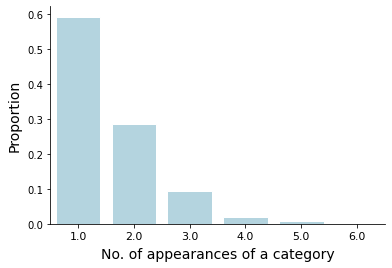

In [216]:
cnts = df['C2'].value_counts().value_counts()
cnts.index = cnts.index/95
cnts = cnts/cnts.sum()

plt.figure(figsize=(6,4))
sns.barplot(x=cnts.index, y=cnts.values, color="lightblue", edgecolor='white')
plt.xticks(size=11)
plt.xlabel(r"No. of appearances of a category", fontsize=14, labelpad=6)
plt.ylabel("Proportion", fontsize=14, labelpad=6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

1. Out of the 2495 categories, over 1400 (~60%) are only associated to a single product.
2. ~90% categories are associated to 1-2 products, indicating that this variable may not be a strong predictor of the outcome.
3. Furthermore using this variable with machine learning models presents further challenges because of its high cardinality.

### C3

Like C1, C3 is a product-level static categorical variable with 6 levels. The proportion of records for each category are roughly equal. This variable may represent the **Product Category**.

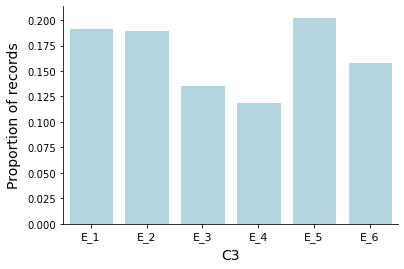

In [277]:
s = df['C3'].value_counts().sort_index()
s = s/s.sum()

plt.figure(figsize=(6,4))
sns.barplot(x=s.index, y=s.values, color="lightblue", edgecolor='white')
plt.xticks(size=11)
plt.xlabel(r"C3", fontsize=14, labelpad=6)
plt.ylabel("Proportion of records", fontsize=14, labelpad=6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

## What's different in units that have a Positive vs Negative correlation bw treatment level and outcome?

In [223]:
pos_corr_df = df[df.unitID.isin(cors[cors >= 0.4].index)]
neg_corr_df = df[df.unitID.isin(cors[cors <= -0.3].index)]

len(pos_corr_df), len(neg_corr_df)

(21565, 25365)

### X2

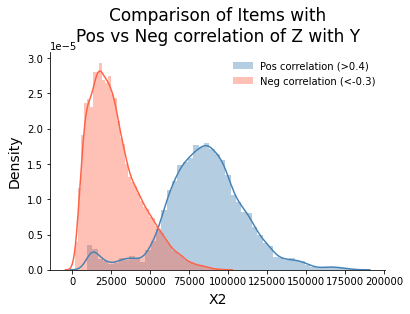

In [232]:
plt.figure(figsize=(6,4))
sns.distplot(pos_corr_df['X2'], color='steelblue', label='Pos correlation (>0.4)')
sns.distplot(neg_corr_df['X2'], color='tomato', label='Neg correlation (<-0.3)')
plt.xlabel(r"X2", fontsize=14, labelpad=6)
plt.ylabel("Density", fontsize=14, labelpad=6)
plt.title("Comparison of Items with\nPos vs Neg correlation of Z with Y", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.show()

The 2 distributions are clearly very different wrt the Covariate X2, and therefore this covariate would be highly predictive of how Z acts on Y. 

### C3

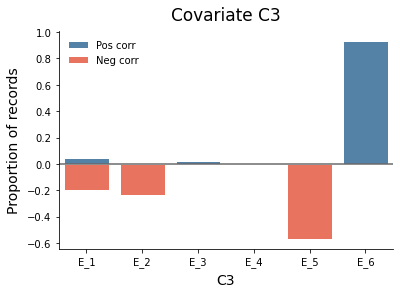

In [285]:
p = pos_corr_df['C3'].value_counts().sort_index()
p = p/p.sum()
p = (pd.Series({f"E_{i}":0 for i in range(1,7)}) + p).fillna(0) # Filling 0 for missing categories
n = neg_corr_df['C3'].value_counts().sort_index()
n = n/n.sum()
n = (pd.Series({f"E_{i}":0 for i in range(1,7)}) + n).fillna(0)

plt.figure(figsize=(6,4))
sns.barplot(x=p.index, y=p.values, color="steelblue", edgecolor='white', label='Pos corr')
sns.barplot(x=n.index, y=-n.values, color="tomato", edgecolor='white', label='Neg corr')
plt.axhline(y=0, color='dimgray')
plt.xlabel(r"C3", fontsize=14, labelpad=6)
plt.ylabel("Proportion of records", fontsize=14, labelpad=6)
plt.title("Covariate C3", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.show()

The covariate C3 (which we designated as the Product Category) is highly predictive of how a product would react to different pricing strategies (treatments).

### No major difference for other covariates

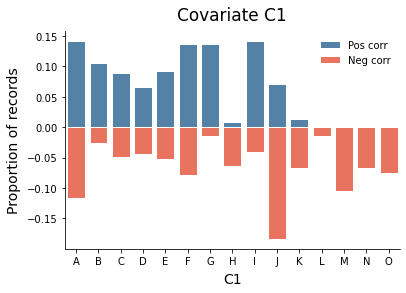

In [282]:
p = pos_corr_df['C1'].value_counts().sort_index()
p = p/p.sum()
n = neg_corr_df['C1'].value_counts().sort_index()
n = n/n.sum()

plt.figure(figsize=(6,4))
sns.barplot(x=p.index, y=p.values, color="steelblue", edgecolor='white', label='Pos corr')
sns.barplot(x=n.index, y=-n.values, color="tomato", edgecolor='white', label='Neg corr')
plt.xlabel(r"C1", fontsize=14, labelpad=6)
plt.ylabel("Proportion of records", fontsize=14, labelpad=6)
plt.title("Covariate C1", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.show()

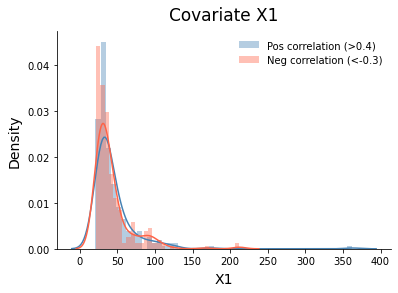

In [266]:
plt.figure(figsize=(6,4))
sns.distplot(pos_corr_df.groupby(by='unitID')['X1'].first(), color='steelblue', label='Pos correlation (>0.4)')
sns.distplot(neg_corr_df.groupby(by='unitID')['X1'].first(), color='tomato', label='Neg correlation (<-0.3)')
plt.xlabel(r"X1", fontsize=14, labelpad=6)
plt.ylabel("Density", fontsize=14, labelpad=6)
plt.title("Covariate X1", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.show()

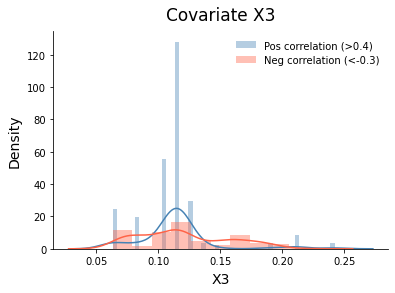

In [264]:
plt.figure(figsize=(6,4))
sns.distplot(pos_corr_df.groupby(by='unitID')['X3'].mean(), color='steelblue', label='Pos correlation (>0.4)')
sns.distplot(neg_corr_df.groupby(by='unitID')['X3'].mean(), color='tomato', label='Neg correlation (<-0.3)')
plt.xlabel(r"X3", fontsize=14, labelpad=6)
plt.ylabel("Density", fontsize=14, labelpad=6)
plt.title("Covariate X3", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.show()